In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [10]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [5]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [7]:
import requests
import json
url = "https://raw.githubusercontent.com/duhaime/umap-zoo/03819ed0954b524919671a72f61a56032099ba11/data/json/bison.json"
animal = np.array(json.loads(requests.get(url).text)['3d'])
np.shape(animal)

(50000, 3)

(-1.0595327718040621,
 0.9895327718040622,
 -0.49177443340691684,
 0.6626744334069168)

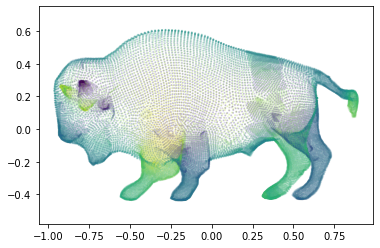

In [8]:
fig, ax = plt.subplots()
ax.scatter(animal[:,2], animal[:,1], s = 1, c = animal[:,0], alpha = 0.1)
ax.axis('equal')

In [11]:
X_train = animal
Y_train = animal[:, 2]
X_train_flat = X_train

### Create model and train

In [15]:
dims = (3)
dataset = 'bison'

In [16]:
n_components = 2
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(
    tf.keras.layers.Dense(units=n_components, name="z")
)

In [17]:
batch_size = 5000

In [18]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [19]:
from tfumap.parametric_tsne import compute_joint_probabilities, tsne_loss

In [31]:
P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=500, verbose=2)
ensure_dir(save_loc)
np.save(save_loc, P)

Precomputing P-values...


Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-values 3500 of 5000 datapoints...
Computed P-values 4000 of 5000 datapoints...
Computed P-values 4500 of 5000 datapoints...
Mean value of sigma: 0.18322350682177363
Minimum value of sigma: 0.1109533757888513
Maximum value of sigma: 0.2940811917609304
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed

In [32]:
X_train_subset = X_train[:np.product(P.shape[:2])]

In [33]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train_subset.shape[0], -1)

In [34]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [35]:
encoder.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [36]:
X_train_subset = np.reshape(X_train_subset, ([len(X_train_subset)]+ [dims]))

In [37]:
# because shuffle == False, the same batches are used each time...
history = encoder.fit(X_train_subset, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0720 13:03:45.557429 140542006703936 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples
Epoch 1/1000
50000/50000 [==============================] - 6s 122us/sample - loss: 0.8303
Epoch 2/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.7152
Epoch 3/1000
50000/50000 [==============================] - 0s 10us/sample - loss: 0.6363
Epoch 4/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.5975
Epoch 5/1000
50000/50000 [==============================] - 0s 10us/sample - loss: 0.5645
Epoch 6/1000
50000/50000 [==============================] - 0s 10us/sample - loss: 0.5502
Epoch 7/1000
50000/50000 [==============================] - 0s 10us/sample - loss: 0.5382
Epoch 8/1000
50000/50000 [==============================] - 0s 10us/sample - loss: 0.5225
Epoch 9/1000
50000/50000 [==============================] - 0s 10us/sample - loss: 0.5122
Epoch 10/1000
50000/50000 [==============================] - 0s 10us/sample - loss: 0.5075
Epoch 11/1000
50000/50000 [==============================] - 1s 10us/sample

50000/50000 [==============================] - 1s 11us/sample - loss: 0.4631
Epoch 91/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4616
Epoch 92/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4629
Epoch 93/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4627
Epoch 94/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4619
Epoch 95/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4634
Epoch 96/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4653
Epoch 97/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4661
Epoch 98/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4633
Epoch 99/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4637
Epoch 100/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4613
Epoch 101/10

50000/50000 [==============================] - 1s 11us/sample - loss: 0.4573
Epoch 180/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4581
Epoch 181/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4578
Epoch 182/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4575
Epoch 183/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4575
Epoch 184/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4585
Epoch 185/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4587
Epoch 186/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4570
Epoch 187/1000
50000/50000 [==============================] - 0s 10us/sample - loss: 0.4552
Epoch 188/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4545
Epoch 189/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4552
Epo

50000/50000 [==============================] - 1s 11us/sample - loss: 0.4531
Epoch 269/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4531
Epoch 270/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 0.4530
Epoch 271/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4522
Epoch 272/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4525
Epoch 273/1000
50000/50000 [==============================] - 1s 13us/sample - loss: 0.4513
Epoch 274/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4518
Epoch 275/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4522
Epoch 276/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 0.4538
Epoch 277/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4530
Epoch 278/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4525
Epo

50000/50000 [==============================] - 1s 11us/sample - loss: 0.4528
Epoch 358/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4521
Epoch 359/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 0.4519
Epoch 360/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4505
Epoch 361/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4520
Epoch 362/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4518
Epoch 363/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4516
Epoch 364/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4512
Epoch 365/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4520
Epoch 366/1000
50000/50000 [==============================] - 1s 12us/sample - loss: 0.4507
Epoch 367/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4508
Epo

50000/50000 [==============================] - 1s 11us/sample - loss: 0.4506
Epoch 447/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4490
Epoch 448/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4488
Epoch 449/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4478
Epoch 450/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4482
Epoch 451/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4485
Epoch 452/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4493
Epoch 453/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4490
Epoch 454/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4493
Epoch 455/1000
50000/50000 [==============================] - 0s 10us/sample - loss: 0.4509
Epoch 456/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4504
Epo

50000/50000 [==============================] - 1s 10us/sample - loss: 0.4466
Epoch 536/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4472
Epoch 537/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4457
Epoch 538/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4483
Epoch 539/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4483
Epoch 540/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4484
Epoch 541/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4474
Epoch 542/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4470
Epoch 543/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4469
Epoch 544/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4468
Epoch 545/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4465
Epo

Epoch 624/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4472
Epoch 625/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4471
Epoch 626/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4461
Epoch 627/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4463
Epoch 628/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4474
Epoch 629/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4491
Epoch 630/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4495
Epoch 631/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4505
Epoch 632/1000
50000/50000 [==============================] - 1s 13us/sample - loss: 0.4494
Epoch 633/1000
50000/50000 [==============================] - 1s 12us/sample - loss: 0.4496
Epoch 634/1000
50000/50000 [==============================] - 1s 11us/sample - l

50000/50000 [==============================] - 1s 11us/sample - loss: 0.4446
Epoch 714/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4455
Epoch 715/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4477
Epoch 716/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4450
Epoch 717/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4476
Epoch 718/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4468
Epoch 719/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4467
Epoch 720/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4464
Epoch 721/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4464
Epoch 722/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4466
Epoch 723/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4504
Epo

50000/50000 [==============================] - 1s 11us/sample - loss: 0.4451
Epoch 803/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4463
Epoch 804/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4462
Epoch 805/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4462
Epoch 806/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4446
Epoch 807/1000
50000/50000 [==============================] - 1s 13us/sample - loss: 0.4442
Epoch 808/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4459
Epoch 809/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4460
Epoch 810/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4448
Epoch 811/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4447
Epoch 812/1000
50000/50000 [==============================] - 1s 10us/sample - loss: 0.4451
Epo

50000/50000 [==============================] - 1s 11us/sample - loss: 0.4458
Epoch 892/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4448
Epoch 893/1000
50000/50000 [==============================] - 1s 13us/sample - loss: 0.4453
Epoch 894/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 0.4461
Epoch 895/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4440
Epoch 896/1000
50000/50000 [==============================] - 1s 13us/sample - loss: 0.4449
Epoch 897/1000
50000/50000 [==============================] - 1s 13us/sample - loss: 0.4437
Epoch 898/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4445
Epoch 899/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4432
Epoch 900/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4448
Epoch 901/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4457
Epo

50000/50000 [==============================] - 1s 11us/sample - loss: 0.4467
Epoch 981/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4467
Epoch 982/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4456
Epoch 983/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 0.4444
Epoch 984/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4423
Epoch 985/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4437
Epoch 986/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4421
Epoch 987/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4425
Epoch 988/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4448
Epoch 989/1000
50000/50000 [==============================] - 1s 11us/sample - loss: 0.4444
Epoch 990/1000
50000/50000 [==============================] - 1s 13us/sample - loss: 0.4437
Epo

In [38]:
z = encoder.predict(X_train)

### Plot model output

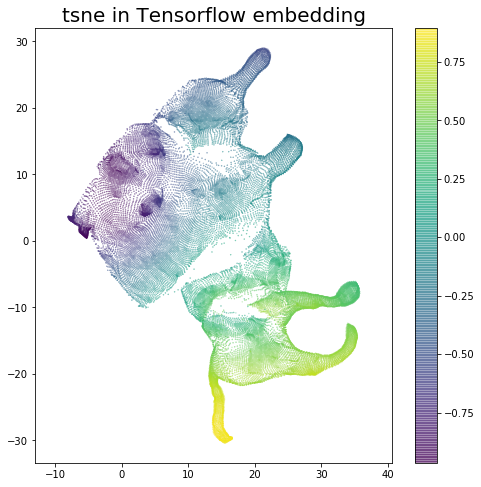

In [39]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train[:len(z)],
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("tsne in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

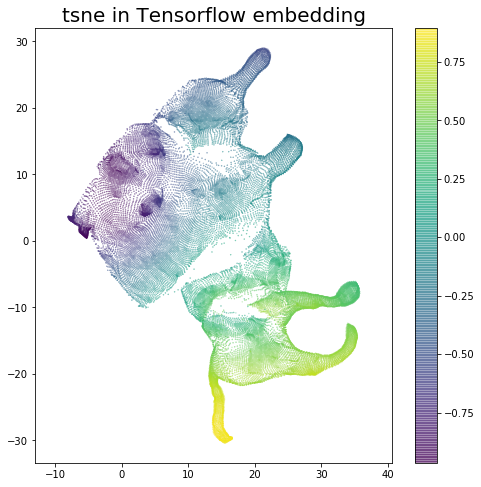

In [41]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train[:len(z)],
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("tsne in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [42]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

### Save output

In [47]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [56]:
output_dir = MODEL_DIR/'projections'/ dataset / 'parametric-tsne'
ensure_dir(output_dir)

In [57]:
output_dir

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/bison/parametric-tsne')

In [58]:
np.save(output_dir / 'z.npy', z)